# Sentiment Analysis with BERT

In this notebook we will work with a pre-trained BERT model. This model will be fine-tuned for a sentiment analysis task given training and test partitions extracted from the well known IMDB database.

Using the test data, we will also see an application example of a particular model explainability technique.

## Preliminary Test

Applying BERT for sentiment analysis is very easy with [Hugging Face](https://huggingface.co/) and its `pipeline` objects.

In [1]:
!pip install transformers emoji

In [2]:
from transformers import pipeline
model_name = "finiteautomata/bertweet-base-sentiment-analysis"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)
data = ["I love you", "I hate you"]
sentiment_pipeline(data)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[{'label': 'POS', 'score': 0.9916695356369019},
 {'label': 'NEG', 'score': 0.9806600213050842}]

## Fine-Tuning Experiment

Alternatively, we can choose a basic, pre-trained model, and fine-tune it by ourselves so as to carry sentiment analysis tasks.

### Install Libraries

In [3]:
import torch
torch.cuda.is_available()
!pip install datasets transformers evaluate
!pip install accelerate -U
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


### Model Definition

We start with a distilled BERT base model. The model is uncased, since it is case insensitive when analyzing input text.

In [4]:
model_name="distilbert-base-uncased"

### Data Preparation

In this session we will work with the well known IMDB dataset, where user movie reviews provided within the [IMDB](https://www.imdb.com/) online database should be classified into two classes: negative (`LABEL_0`) and positive (`LABEL_1`). The dataset can be easily loaded using the `datasets` module provided by HuggingFace.

In [5]:
from datasets import load_dataset
imdb = load_dataset("imdb")

Next, we filter the data, obtaining a smaller dataset that is faster to work with:

In [6]:
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(2000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(200))])

Now we proceed to preprocess the data using a tokenizer specific for the model we will work with.

In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

We also define a collator to speed up training. Data collators are specialized objects whose purpose is to build batches of samples. The samples that compose a given batch can be processed in parallel during training, allowing to fully exploit the processing abilities of GPUs and thus improving the efficiency of the training process.

In [9]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Model Training

Once the data has been prepared, we can go ahead with model training. For this purpose, we need to instantiate a particular model, define the metrics we want to use to evaluate it, and finally, configure the rest of the training hyperparameters.

In [10]:
from transformers import AutoModelForSequenceClassification

model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
import numpy as np
import evaluate

def compute_metrics(eval_pred):
    load_accuracy = evaluate.load("accuracy")
    load_f1 = evaluate.load("f1")
    auc_metric = evaluate.load("roc_auc")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    roc_auc = auc_metric.compute(prediction_scores=predictions, references=labels)["roc_auc"]

    return {"accuracy": accuracy, "f1": f1, "roc_auc": roc_auc}

In [12]:
!pip install transformers[torch]

In [13]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model = 'eval_roc_auc',
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

At this point, we are ready to launch the training process:

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

### Analyzing New Data

Once the model has been fine-tuned, we can test it with a couple of sentences by defining a pipeline object.

In [15]:
from transformers import pipeline

sentiment_model = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
sentiment_model(["I love this move", "This movie sucks!"])

[{'label': 'LABEL_0', 'score': 0.5538505911827087},
 {'label': 'LABEL_0', 'score': 0.5555700063705444}]

## Explainability Experiment

After testing our model, we will carry a out an explainability experiment, so as to identify, for our IMDB test set, the words that are more relevant for the classifier to make its predictions.

For this purpose, we are going to apply the [Transformers Interpret](https://github.com/cdpierse/transformers-interpret) package, which is internally based on the more general [Captum](https://captum.ai/) library. The explainability method that is applied is called [integrated gradients](https://arxiv.org/pdf/1703.01365.pdf).

In [16]:
!pip install transformers-interpret wordcloud matplotlib
from transformers_interpret import SequenceClassificationExplainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 958.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.3 MB/s eta 0:00:00


### Create Explainer

We use our model and its tokenizer is required to instantiate an *explainer* object, defined by the Transformers Interpret package.

In [17]:
cls_explainer = SequenceClassificationExplainer(model, tokenizer)

### Explainability Example

First, we execute the explainer on a single sentence and graphically visualize the so-called word attribution scores. The attribution scores for a given word may be positive (meaning that the certainty of the classifier about the predicted class would decrease if the word was removed) or negative (meaning that the certainty of the classifier about the predicted would increase if the word was removed).

In [18]:
word_attributions = cls_explainer("This movie sucks!")
cls_explainer.visualize(true_class='LABEL_0')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
LABEL_0,LABEL_0 (0.52),LABEL_0,-0.28,[CLS] this movie sucks ! [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
LABEL_0,LABEL_0 (0.52),LABEL_0,-0.28,[CLS] this movie sucks ! [SEP]


### Obtain Attribution Scores

First of all, we need to register the word attribution scores for all of the sentences in the test set. In order to perform further computations, it is also important to also register the predicted and true classes for each sentence. We will store this information in the `all_word_attributions` variable.

In [ ]:
def get_first_n_words(original_string, n):
    words = original_string.split()
    first_n_words = ' '.join(words[:n])
    return first_n_words

# Set the desired maximum number of words (ideally the whole sentences should
# be considered, but here we limit the length to reduce the computational cost)
max_words = 50

# List to store word attributions for each sample
all_word_attributions = []

for i in range(small_test_dataset.num_rows):
    text = small_test_dataset['text'][i]
    truncated_text = get_first_n_words(text, max_words)

    # Obtain word attributions
    word_attributions = cls_explainer(truncated_text)

    # Obtain class information
    true_class = small_test_dataset['label'][i]
    predicted_class = cls_explainer.predicted_class_name

    # Save the filtered attributions for this row along with true_class and predicted_class
    attribution_info = (word_attributions, true_class, predicted_class)
    all_word_attributions.append(attribution_info)

In [20]:
import pickle

# Save all_word_attributions to a file
with open('all_word_attributions.pkl', 'wb') as file:
    pickle.dump(all_word_attributions, file)

### Obtain Positive Attribution Scores

After storing the importance information, we will extract the positive attribution scores for the the two classes being considered. Thus, we will focus on those words that contributed favorably to classify a sentence into positive or negative sentiment. As a result of the previous computations, we will obtain a list of pairs containing a word and its score for `LABEL_0` (negative sentiment), and another one for `LABEL_1` (positive sentiment).

In [21]:
import pickle

# Load the previously saved attributions from the file
with open('all_word_attributions.pkl', 'rb') as file:
    all_word_attributions = pickle.load(file)

In [22]:
def filter_attributions(attributions, sign, label):
    attrs = []
    for attributions, true_class, predicted_class in attributions:
        #print(true_class, predicted_class)
        if predicted_class == label:
            for word, score in attributions:
                if sign == '+':
                    if score > 0:
                        attrs.append((word, score))
                else:
                    if score < 0:
                        attrs.append((word, score))
    return attrs

# Get positive attributions for the two labels
positive_attributions_label_1 = filter_attributions(all_word_attributions, '+', "LABEL_1")
positive_attributions_label_0 = filter_attributions(all_word_attributions, '+', "LABEL_0")

### Obtain List of Stop Words

We use the [nltk](https://www.nltk.org/) library to generate a list of stop words that will be useful for filtering purposes. More specifically, all of the words in the list will be excluded when representing the results.

In [23]:
!pip install nltk

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
english_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Obtain List of Valid Words

Again we use nltk to obtain a list of valid English words that will be useful for filtering purposes.

In [24]:
nltk.download('words')
english_words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


### Define Filtering Functions

In [25]:
def filter_stop_words(stopwords, word_score_pairs):
    return [(word, score) for word, score in word_score_pairs if word not in stopwords]

def filter_words(validwords, stopwords, word_score_pairs):
    return [(word, score) for word, score in word_score_pairs if word not in stopwords and word in validwords]

### Generate Word Clouds

We will use the [wordcloud](https://pypi.org/project/wordcloud/) Python package to graphically represent the words with greater positive attribution according to the explainer. For this purpose, we need to accumulate the scores for each word. After computing the accumulated scores, we can generate the word cloud.

In [26]:
def accum_scores(word_score_pairs):
    result = {}
    for word, score in word_score_pairs:
        if word in result:
            result[word] = result[word] + score
        else:
            result[word] = score
    return result

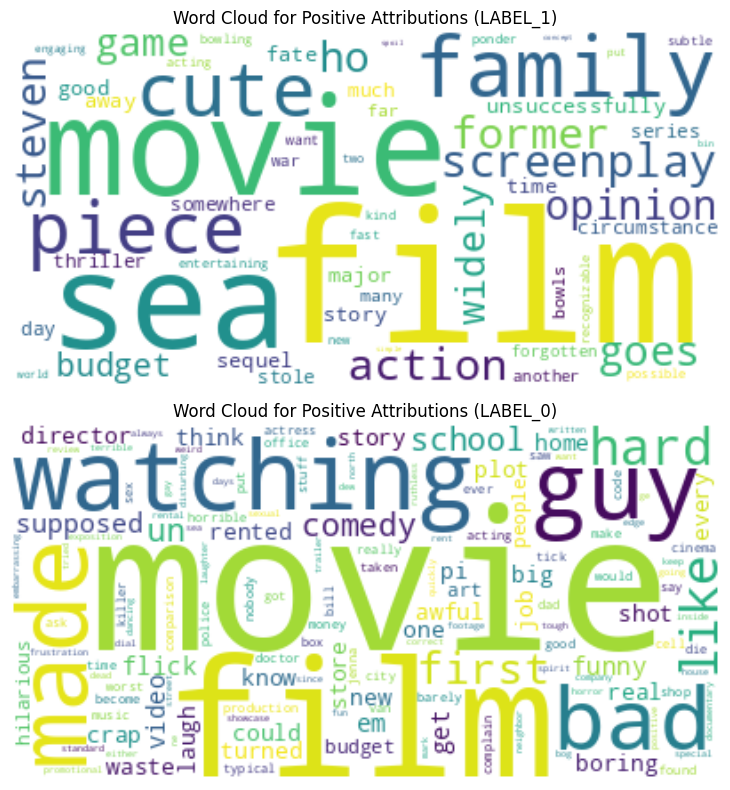

In [27]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

# Obtain accumulated word scores
positive_words_label_1 = accum_scores(filter_words(english_words, english_stopwords, positive_attributions_label_1))
positive_words_label_0 = accum_scores(filter_words(english_words, english_stopwords, positive_attributions_label_0))

# Generate word clouds
wordcloud_label_1_positive = WordCloud(background_color='white').generate_from_frequencies(positive_words_label_1)
wordcloud_label_0_positive = WordCloud(background_color='white').generate_from_frequencies(positive_words_label_0)

# Plot word clouds
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.imshow(wordcloud_label_1_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Attributions (LABEL_1)')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(wordcloud_label_0_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Attributions (LABEL_0)')
plt.axis('off')

plt.tight_layout()
plt.show()